In [1]:
import sys

sys.path.append("..")

In [2]:
import pandas as pd

from src.transformers import *
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    BaggingRegressor,
)
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [3]:
# Set this flag if this is for submission
is_submission = True

In [4]:
train = pd.read_csv("../data/processed/train.csv", sep=",")
test = pd.read_csv("../data/processed/test.csv", sep=",")

print("The shape of train is {}".format(train.shape))
print("The shape of test is {}".format(test.shape))

The shape of train is (16780, 50)
The shape of test is (5000, 49)


In [5]:
test.head(5)

,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,transmission,...,coe_expiry_months,vehicle_age,is_parf_car,parf,coe_rebate,dereg_value_computed,lifespan_restriction,features_count,accessories_count,brand_rank
0,bmw x6 xdrive35i sunroof (new 10-yr coe),bmw,x6,"owner consignment unit, viewing strictly by ap...",2012.0,NaN,2012-06-27 00:00:00,suv,coe car,auto,...,9.410460,9.0,0,0.00,4813.874077,4813.874077,1,2,6,3
1,porsche 911 carrera s coupe 3.8a pdk (coe till...,porsche,911,the 911 carrera s displacing 3.8 litres with m...,2010.0,NaN,2010-05-11 00:00:00,sports car,"coe car, direct owner sale",auto,...,88.274332,11.0,0,0.00,23211.000000,23211.000000,1,2,7,5
2,porsche macan diesel s 3.0a pdk,porsche,macan,comes with agent warranty till january 2022. a...,2016.0,NaN,2017-01-18 00:00:00,suv,"parf car, premium ad car",auto,...,64.146697,5.0,1,68502.00,28388.120783,96890.120783,1,1,9,5
3,bmw 5 series 530i luxury,bmw,530i,a careful owner upgraded to a porsche macan. t...,2017.0,NaN,2017-06-28 00:00:00,luxury sedan,"parf car, sgcarmart warranty cars",auto,...,69.436333,4.0,1,45831.75,27485.793938,73317.543938,1,5,8,3
4,honda vezel 1.5a x,honda,vezel,100% non phv-unit! excellent condition and wel...,2016.0,NaN,2017-06-05 00:00:00,suv,parf car,auto,...,68.680671,5.0,1,7180.60,26607.464308,33788.064308,1,7,6,2


In [6]:
class PostProcessing(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.columns_to_drop = [
            "listing_id",
            "title",
            "model",
            "description",
            "original_reg_date",
            "reg_date",
            "category",
            "lifespan",
            "features",
            "accessories",
            "eco_category",
            "indicative_price",
            "reg_date_year",
            "reg_date_month",
            "coe_start_date",
            "coe_start_year",
            "coe_rebate",
            "dereg_value_computed",
            "manufactured",
            "mileage", "make_model", "engine_cap_range", "price"
        ]
        pass

    def fit(self, X):
        return self

    def transform(self, X):
        df = X.copy()
        df.loc[:,'last_reg_age'] = datetime.now().year - pd.to_datetime(df.reg_date).dt.year
        df.loc[:, 'mileage_log'] = np.log(df.mileage)
        df = df.drop(self.columns_to_drop, axis=1, errors="ignore")
        return df

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

pipe = Pipeline(
    [
        ("add_cat", SplitValuesToColumn("category")),
        ("post_processing", PostProcessing()),
        ('ohe', OheCategorical(['type_of_vehicle', 'transmission', 'brand_rank', 'opc_scheme', 'fuel_type', "make"]))
    ]
)

In [8]:
trainX = train
trainY = train.loc[:, 'price']

In [9]:
# list(X_train.columns)

In [10]:
if not is_submission:
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, test_size=0.2, random_state=72)

    X_train.reset_index(inplace=True, drop=True)
    X_test.reset_index(inplace=True, drop=True)

    y_train.reset_index(inplace=True, drop=True)
    y_test.reset_index(inplace=True, drop=True)

In [11]:
if is_submission:
    X_train = pipe.fit_transform(trainX)
    X_test = pipe.transform(test)
    y_train=trainY
else:
    X_train = pipe.fit_transform(X_train)
    X_test = pipe.transform(X_test)

print(f"X_Train:{X_train.shape}")

X_Train:(16780, 143)


In [18]:
1e-5 == 0.00001

True

In [20]:
# Defining various algorithms

models = [
#     {"name": type(RandomForestRegressor()).__name__, "model": RandomForestRegressor, "params":{
#     "max_depth": [40, 50, 60, 100],
#     "max_features": ["sqrt"],
#     "n_estimators": [100, 200, 400]}
#     },
    {"name": type(GradientBoostingRegressor()).__name__, "model": GradientBoostingRegressor, "params":{
    "n_estimators": [1000],
    "learning_rate": [0.05],
    "max_depth": [5, 10],
    "max_features": ["sqrt"]}
    },
    {"name": type(Ridge()).__name__, "model": Ridge, "params":{
    "solver": ["svd", "cholesky", "lsqr", "sag"],
    "alpha": [0.00001, 0.0001, 0.01],
    "fit_intercept": [True, False],
    "normalize": [True, False]}
    },
    {"name": type(KNeighborsRegressor()).__name__, "model": KNeighborsRegressor, "params":{
    "n_neighbors": [1, 3, 5]}
    }
]

In [21]:
best_model = None
best_score = None
best_params = {}
for model in models:
    print(f"*** Training Model: {model['name']}")
    model_tuning = GridSearchCV(
        estimator=model['model'](),
        param_grid=model['params'],
        cv=3,
        verbose=3,
        n_jobs=-1,
    )

    model_tuning.fit(X_train, y_train)
    print(f"Best Params {model_tuning.best_params_}")
    print(f"Best Score {model_tuning.best_score_}")
    print("\n\n")
    
    if (best_score is None or best_score < model_tuning.best_score_):
        best_score = model_tuning.best_score_
        best_model = model['model']
        best_params = model_tuning.best_params_

print(f"Best Model: {best_model.__name__}")

*** Training Model: GradientBoostingRegressor
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Params {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 1000}
Best Score 0.9645220326644027



*** Training Model: Ridge
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Params {'alpha': 0.01, 'fit_intercept': True, 'normalize': True, 'solver': 'svd'}
Best Score 0.8615926736854366



*** Training Model: KNeighborsRegressor
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Params {'n_neighbors': 5}
Best Score 0.9046684746588493



Best Model: GradientBoostingRegressor


In [22]:
final_model = best_model(**best_params)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)


In [23]:
if not is_submission:
    mean_squared_error(y_test, y_pred, squared=False)

In [24]:
X_test

,curb_weight,power,engine_cap,no_of_owners,depreciation,coe,road_tax,dereg_value,omv,arf,...,"(skoda_make,)","(ssangyong_make,)","(subaru_make,)","(suzuki_make,)","(tesla_make,)","(toyota_make,)","(ud_make,)","(volkswagen_make,)","(volvo_make,)","(yutong_make,)"
0,2070.0,225.0,2979.0,3.0,14870.0,61385.402899,2362.0,4813.874077,68994.0,68994.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1530.0,283.0,3800.0,5.0,31920.0,31553.000000,4366.0,23211.000000,115405.0,115405.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1955.0,190.0,2967.0,3.0,26640.0,53106.000000,3336.0,102072.000000,69922.0,97860.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1540.0,185.0,1998.0,1.0,19390.0,47501.000000,1210.0,73330.000000,49363.0,61109.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1190.0,96.0,1496.0,2.0,9620.0,46489.000000,682.0,34555.000000,20184.0,10258.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1449.0,84.0,1600.0,2.0,9640.0,36001.000000,744.0,32035.000000,13452.0,13452.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4996,1775.0,125.0,2362.0,1.0,15860.0,41001.000000,1638.0,62123.000000,34487.0,40282.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4997,1405.0,100.0,1598.0,1.0,14610.0,72369.000000,742.0,36502.000000,35847.0,32186.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4998,1190.0,96.0,1496.0,1.0,11390.0,53334.000000,682.0,42129.000000,23650.0,20110.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
my_submission = pd.DataFrame({'Id': list(test.index), 'Predicted': y_pred})
my_submission.to_csv('submission.csv', index=False)

<AxesSubplot:>

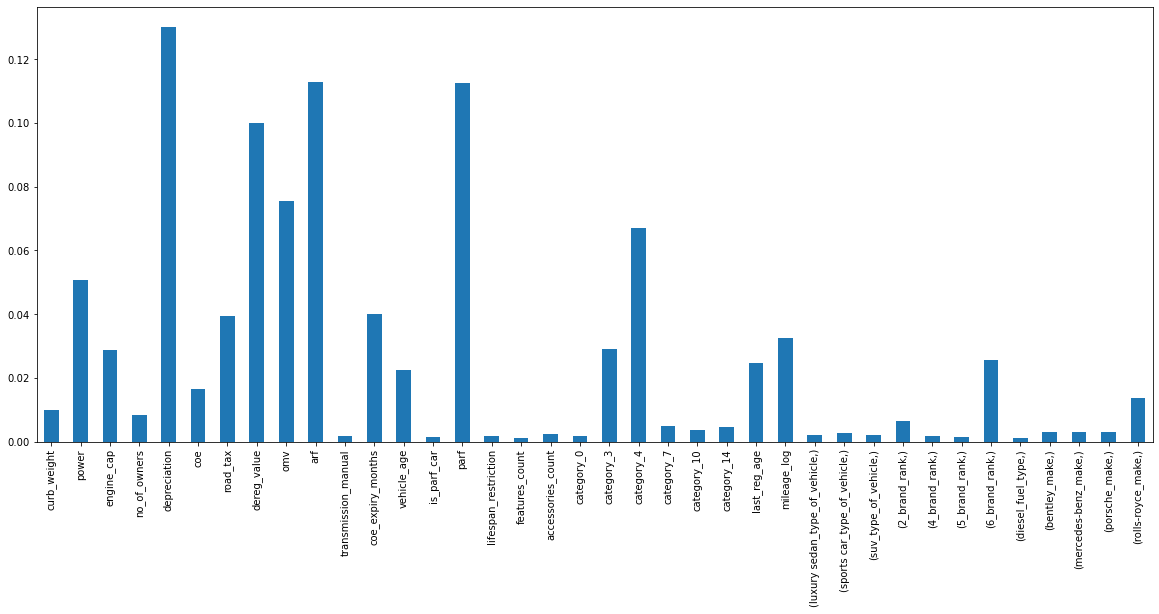

In [27]:
# plot feature importance

%matplotlib inline
import matplotlib.pyplot as plt

forest_importances = pd.Series(final_model.feature_importances_, index=list(X_train.columns))
forest_importances = forest_importances[forest_importances > 0.001]

plt.figure(figsize=(20,8))
forest_importances.plot.bar()

In [ ]:
# y_pred = best_model.predict(X_test)
# df = DataFrame(y_pred, columns=["Predicted"], )
# df.index.rename("Id", inplace=True)
# df.to_csv("dump.csv")

In [ ]:
X_test.head(5)